# Separate three donuts using a multilayer perceptron

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

In [3]:
np.random.seed(3)

In [4]:
from lib.mlp import MLP

## Generate donuts

In [5]:
def donut(r_min, r_max, size):
    rs = np.random.uniform(r_min, r_max, size)
    thetas = np.random.uniform(0, 2 * np.pi, size)

    x1 = np.array([r * np.cos(theta) for r, theta in zip(rs, thetas)])
    x2 = np.array([r * np.sin(theta) for r, theta in zip(rs, thetas)])

    x = np.vstack([x1, x2])
    
    return x

In [6]:
# Numbers of data points for each donut
Ns = [120, 220, 320]

# Radius of each donut
radiuses = [(1, 2), (4, 5), (7, 8)]

# Label of each donut
labels = np.linspace(0, 1, num=len(radiuses))

# Color of each donut
colors = ['g', 'r', 'b']

# Background color of each donut (predictions colors)
bg_colors = [(0.3, 1, 0.3),
             (1, 0.3, 0.3),
             (0.3, 0.3, 1)]

In [7]:
# Guard against wrong sizes for the previously defined objects
assert len(radiuses) == len(Ns)
assert len(labels) == len(radiuses)
assert len(colors) == len(labels)
assert len(bg_colors) == len(colors)

In [8]:
# Data

x_list = []
for (r_min, r_max), N in zip(radiuses, Ns):
    x_list.append(donut(r_min, r_max, N))

x = np.concatenate(x_list, axis=1)

# Labels

y_list = []
for label, N in zip(labels, Ns):
    y_list.append(np.array([[label] * N]))

y = np.concatenate(y_list, axis=1)

In [9]:
# Shuffle dataset
index = list(np.random.permutation(sum(Ns)))
x = x[:, index]
y = y[:, index]

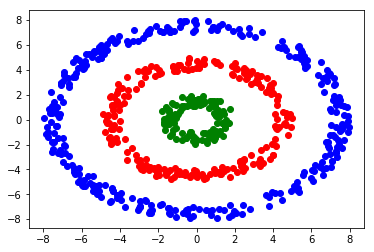

In [10]:
# Plot donuts
for label, color in zip(labels, colors):
    is_that_label = y[0] == label
    plt.plot(*x[:, is_that_label], 'o' + color)

## Fit donuts

In [11]:
# Build background (predictions) colormap
def get_bg_cmap(bg_colors):

    # Get list of colors to build the colormap from
    white = (1, 1, 1)
    cmap_list = []
    for color in bg_colors:
        cmap_list += [color] * 5 + [white]
    
    # Strip extra white element at the end
    cmap_list = cmap_list[:-1]

    # Build colormap
    cmap = LinearSegmentedColormap.from_list('cm', cmap_list, 1000)
    
    return cmap

In [12]:
# Plot data in foreground, predictions in background
def plot_predictions(x, y, model, zoom_out_ratio=1.1):

    # Find data bounds
    x1_min, x2_min = x.min(axis=1)
    x1_max, x2_max = x.max(axis=1)

    x1_range = x1_max - x1_min
    x2_range = x2_max - x2_min

    # Enlarge data bounds for prettier plotting
    x1_min -= (zoom_out_ratio - 1) * x1_range
    x1_max += (zoom_out_ratio - 1) * x1_range
    x2_min -= (zoom_out_ratio - 1) * x2_range
    x2_max += (zoom_out_ratio - 1) * x2_range

    # Size of the background (i.e. number of pixels)
    background_width = 100
    background_height = 100
    background = np.ones(shape=(background_height, background_width))

    # Generate background
    x1_vals = np.linspace(x1_min, x1_max, num=background_width)
    x2_vals = np.linspace(x2_min, x2_max, num=background_height)
    for i, x1_val in enumerate(x1_vals):
        for j, x2_val in enumerate(x2_vals):
            # Convert plot coordinates (i, j) to image coordinates (img_i, img_j)
            img_i = (background_height - 1) - j
            img_j = i
            # Compute backgroup pixel value
            background[img_i, img_j] = model.predict(np.array([[x1_val, x2_val]]).T)
            
    # Plot background
    fig, ax = plt.subplots()
    cmap = get_bg_cmap(bg_colors)
    ax.imshow(background, extent=[x1_min, x1_max, x2_min, x2_max], cmap=cmap)

    # Plot data
    for label, color in zip(labels, colors):
        is_that_label = y[0] == label
        plt.plot(*x[:, is_that_label], 'wo', markersize=4)
        plt.plot(*x[:, is_that_label], 'o' + color, markersize=3)

epoch 10, error = 0.073


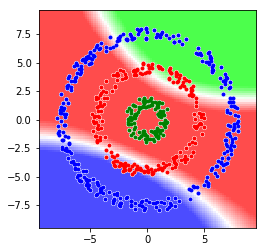

epoch 25, error = 0.072


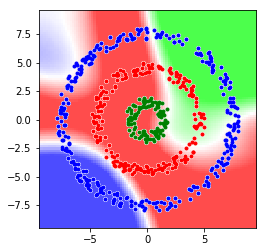

epoch 45, error = 0.068


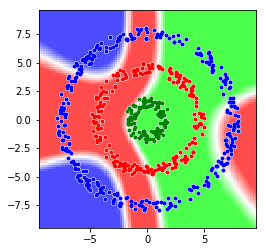

epoch 65, error = 0.034


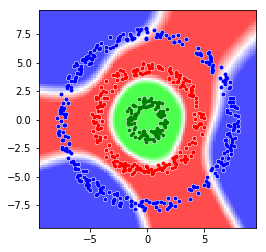

epoch 80, error = 0.006


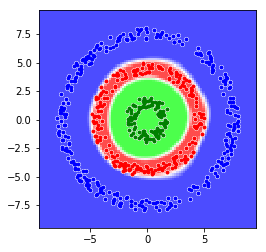

In [13]:
mlp = MLP(layers=[2, 10, 10, 10, 1])

cum_epochs = 0

imgs = []

for epochs in [10, 15, 20, 20, 15]:

    error = mlp.fit(x, y, epochs, batch_size=100, eta=3)
    cum_epochs += epochs

    print('epoch %i, error = %.3f' % (cum_epochs, error))
    plot_predictions(x, y, mlp, zoom_out_ratio=1.1)
    plt.show()